# ARIMA

This notebook demonstrates the application of Autoregressive Integrated Moving Average (ARIMA) models for predicting cryptocurrency price movement, accompanied by mean absolute percentage error calculations for evaluation. Initiated by importing libraries and reading historical csv files, the notebook moves on to analyzing autocorrelation, fitting two unique ARIMA models (namely ARIMA (4,1,0) and ARIMA (1,1,0)), and examining stationarity via Augmented Dickey Fuller tests. The ARIMA models are then scrutinized quantitively, measuring the discrepancies between observations and predictions using mean absolute percentage error. Through harnessing ARIMA models and evaluating performance, the notebook offers perspectives on short-term price pattern recognition and forecasting.

# Table of Contents
- [Import Library](#import-library)
- [Read In CSV](#read-in-csv)
- [Autocorrelation](#autocorrelation)
- [Train Model](#train-model)
    - [Adfuller](#adfuller)
    - [ARIMA (4,1,0) Model](#arima-(4,1,0)-model)
    - [ARIMA (1,1,0) Model](#arima-(1,1,0)-model)
- [Evaluate Model](#evaluate-model)
    - [Evaluate ARIMA (4,1,0) Model](#evaluate-arima-(4,1,0)-model)
    - [Evaluate ARIMA (1,1,0) Model](#evaluate-arima-(1,1,0)-model)

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Read In CSV

In [20]:
eth = pd.read_csv('./data/ohlcv_daily.csv')

In [21]:
eth.set_index('Unnamed: 0', inplace=True)
eth.index = pd.to_datetime(eth.index)

# Autocorrelation

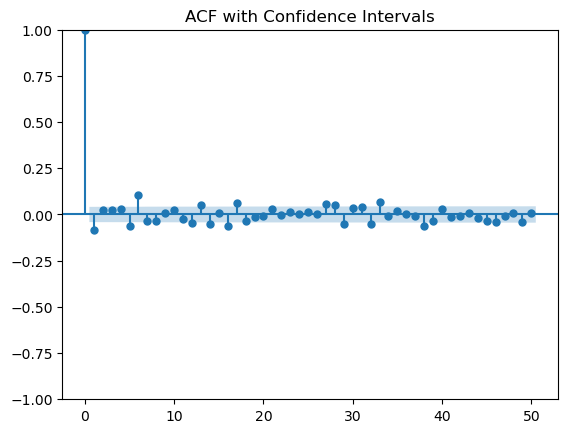

In [23]:
autocorrelation = eth['2017':].resample('D').mean().fillna(method='ffill')['close']
acf_plot = plot_acf(autocorrelation.diff().dropna(), lags=50, alpha=0.05, title='ACF with Confidence Intervals')

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'acf_plot.png'));

- If you observe the autocorrelation value for the present value with itself it is 1.0 since current value is dependent on current value.
- **Lower Bound Statistically Significant Lags:**
> Lags 2, 6, 14, 16, 29, 32, 48 exhibit autocorrelation values that are statistically significant and fall below the lower confidence interval. These lags suggest potential negative correlations beyond what would be expected by random chance.

- **Upper Bound Statistically Significant Lags:**
> Lags 7, 17, 27, 33 exhibit autocorrelation values that are statistically significant and exceed the upper confidence interval. These lags suggest potential positive correlations beyond what would be expected by random chance.

# Train Model

## Adfuller

In [24]:
arima2017hour = eth['2017':].resample('D').mean().fillna(method='ffill')['close']

adfuller(arima2017hour)[1]

0.6190294404168979

> With a high p-value of 0.61 on the ADF test, there is not sufficient evidence to claim this time series is stationary. More specifically, we fail to reject the null hypothesis of a unit root at conventional significance levels.

In [26]:
# 90% training / 10% testing
to_row = int(len(eth)*0.9)

training_data = list(eth[0:to_row]['close'])
testing_data = list(eth[to_row:]['close'])

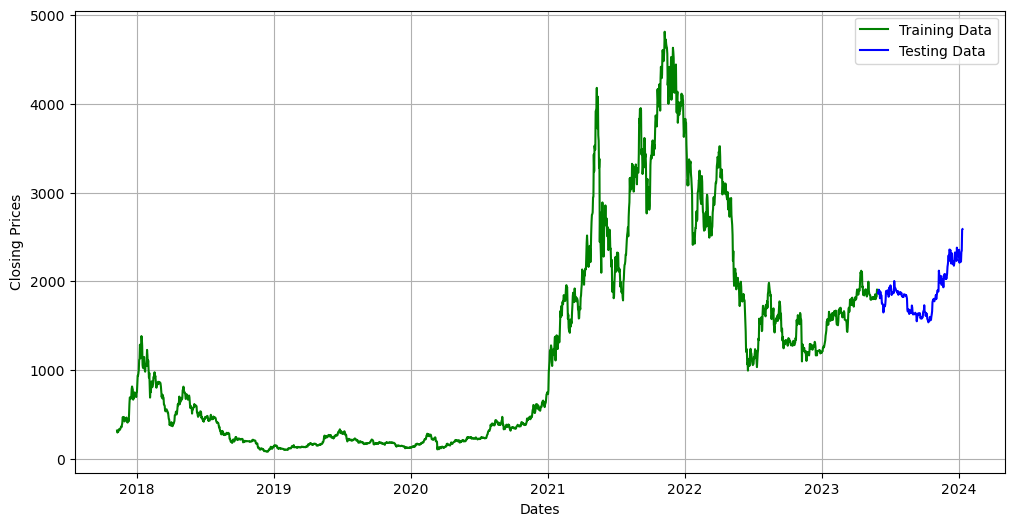

In [27]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(eth[0:to_row]['close'], 'green', label='Training Data')
plt.plot(eth[to_row:]['close'], 'blue', label='Testing Data')
plt.legend();

## ARIMA (4,1,0) Model

In [31]:
model_410_predictions = []

n_test_observations = len(testing_data)

In [32]:
for i in range(n_test_observations):
    model = ARIMA(training_data, order=(4,1,0))
    model_410_fit = model.fit()
    output = model_410_fit.forecast()
    yhat = list(output)[0]
    model_410_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

## ARIMA (1,1,0) Model

In [33]:
# 90% training / 10% testing
to_row = int(len(eth)*0.9)

training_data = list(eth[0:to_row]['close'])
testing_data = list(eth[to_row:]['close'])

In [34]:
model_110_predictions = []

n_test_observations = len(testing_data)

In [35]:
for i in range(n_test_observations):
    model = ARIMA(training_data, order=(1,1,0))
    model_110_fit = model.fit()
    output = model_110_fit.forecast()
    yhat = list(output)[0]
    model_110_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

# Evaluate Model

## Evaluate ARIMA (4,1,0) Model

In [36]:
print(model_410_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2254
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -12932.836
Date:                Fri, 19 Jan 2024   AIC                          25875.672
Time:                        01:48:57   BIC                          25904.272
Sample:                             0   HQIC                         25886.110
                               - 2254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0853      0.011     -7.851      0.000      -0.107      -0.064
ar.L2          0.0175      0.010      1.750      0.080      -0.002       0.037
ar.L3          0.0292      0.010      2.801      0.0

> This SARIMAX model has 4 Autoregressive (AR) terms and no Moving Average or seasonal components. All 4 AR coefficients are statistically significant, with the AR(1) term being negative and the others positive.

> The model exhibits heteroskedasticity according to the statistical test. The residuals also show evidence of non-normality based on the Jarque-Bera test, with the data being negatively skewed and having excess kurtosis.

> Overall, while this SARIMAX model fits the data reasonably well in sample based on the highly significant AR terms and AIC, there are indications of issues with heteroskedasticity and non-normality that may affect reliability of inference and forecasts.

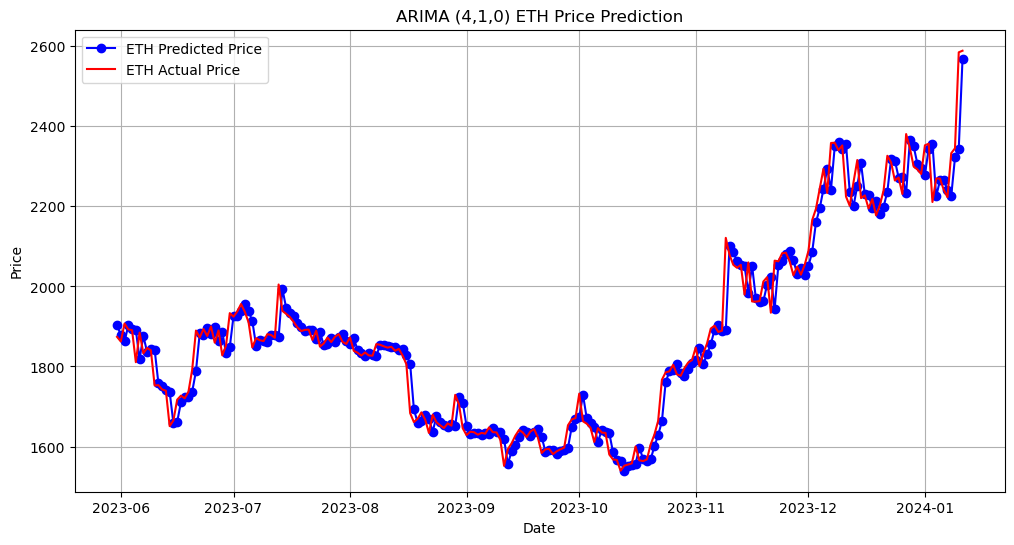

In [37]:
plt.figure(figsize=(12,6))
plt.grid(True)

date_range = eth[to_row:].index

plt.plot(date_range, model_410_predictions, color='blue', marker='o', linestyle='-', label='ETH Predicted Price')
plt.plot(date_range, testing_data, color='red', label='ETH Actual Price')
plt.title('ARIMA (4,1,0) ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'arima_410_prediction.png'));

In [38]:
mape = round(np.mean(np.abs(np.array(model_410_predictions) - np.array(testing_data)) / np.abs(testing_data)), 3)
print(f'Mean Absolute Percentage Error: {str(mape)}')

Mean Absolute Percentage Error: 0.016


> Around 1.6% mean absolute percentage error implies the model is about 98.4% accurate in predicting test observations.

## Evaluate ARIMA (1,1,0) Model

In [39]:
print(model_110_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2254
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12935.158
Date:                Fri, 19 Jan 2024   AIC                          25874.316
Time:                        01:49:07   BIC                          25885.756
Sample:                             0   HQIC                         25878.491
                               - 2254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0854      0.011     -7.886      0.000      -0.107      -0.064
sigma2      5682.4185     54.108    105.020      0.000    5576.369    5788.468
Ljung-Box (L1) (Q):                   0.00   Jarque-

> This SARIMAX model has a single AR(1) term, which is statistically significant with a negative coefficient. No MA or seasonal components are included.

> The model exhibits heteroskedasticity and non-normal residuals, evidenced by test results showing significant p-values. Specifically, the residuals display negative skewness and excess kurtosis.

> The Ljung-Box test indicates no remaining autocorrelation in the residuals. And the overall fit seems reasonable given the highly significant AR coefficient and AIC.

> However, the presence of heteroskedasticity and non-normality may undermine reliability of inference and forecasting. Exploring transformations and additional parameters may improve model quality. But barely, the AR(1) component captures essential data dynamics.

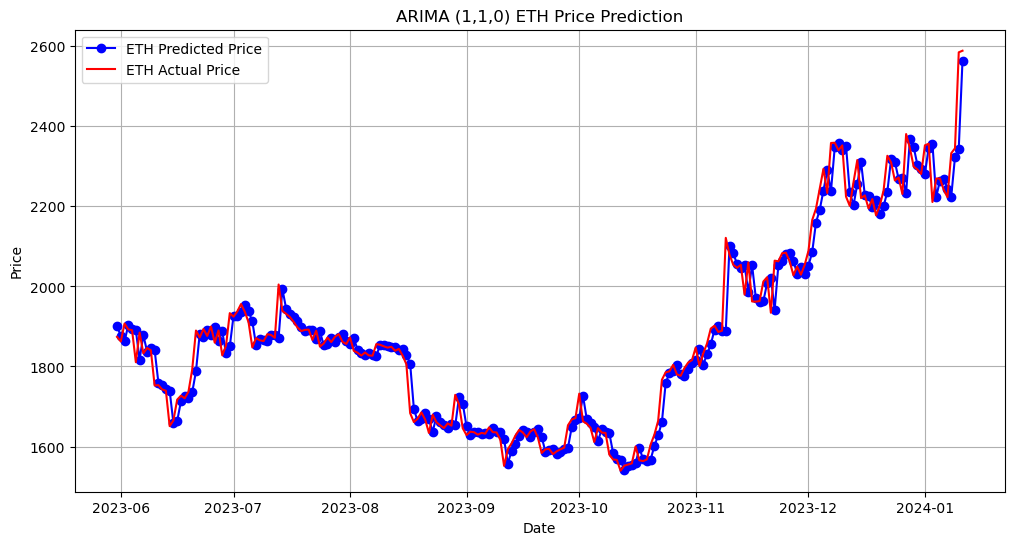

In [40]:
plt.figure(figsize=(12,6))
plt.grid(True)

date_range = eth[to_row:].index

plt.plot(date_range, model_110_predictions, color='blue', marker='o', linestyle='-', label='ETH Predicted Price')
plt.plot(date_range, testing_data, color='red', label='ETH Actual Price')
plt.title('ARIMA (1,1,0) ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'arima_110_prediction.png'));

In [41]:
mape = round(np.mean(np.abs(np.array(model_110_predictions) - np.array(testing_data)) / np.abs(testing_data)), 3)
print(f'Mean Absolute Percentage Error: {str(mape)}')

Mean Absolute Percentage Error: 0.016


> Around 1.6% mean absolute percentage error implies the model is about 98.4% accurate in predicting test observations.